# **Strain evaluation**

In [1]:
%matplotlib widget

In [2]:
from bmcs_shear.dic_crack import DICGrid, DICAlignedGrid, DICCOR
import ibvpy.api as ib
import numpy as np
import matplotlib.pylab as plt

In [3]:
dic_grid = DICGrid(n_x=59, n_y=15, d_x = 22, d_y = 22,  
                     start_t = 0, end_t =8, U_factor = 100, dir_name='B1_TV1')

In [4]:
n_x, n_y = dic_grid.n_x, dic_grid.n_y
L_x, L_y = dic_grid.L_x, dic_grid.L_y

In [5]:
L_x

1276.0

Construct the FEGrid  with the same structure as DICGrid 

In [6]:
xdomain = ib.XDomainFEGrid(coord_min=(L_x, 0),
                 coord_max=(0, L_y),
                 integ_factor=1,
                 shape=(n_x-1, n_y-1), # number of elements!
                 fets=ib.FETS2D4Q());

Check if the order of nodes is consistent in dic_grid and in xdomain

In [7]:
xdomain.mesh.X_Id[:15]

array([[1276.,    0.],
       [1276.,   22.],
       [1276.,   44.],
       [1276.,   66.],
       [1276.,   88.],
       [1276.,  110.],
       [1276.,  132.],
       [1276.,  154.],
       [1276.,  176.],
       [1276.,  198.],
       [1276.,  220.],
       [1276.,  242.],
       [1276.,  264.],
       [1276.,  286.],
       [1276.,  308.]])

Since the fe_grid does not distinguish the ij coordinates but only I
reshape the dic_grid in the same way to ensure the order of nodes is the same

In [8]:
X_ija = dic_grid.X_ija

In [9]:
X_Ia = X_ija.reshape(-1,2)

Now check that the first five nodes are ordered in the same way as above in `xdomain.mesh.X_Id` 

In [10]:
X_Ia[:15]

array([[1276.,    0.],
       [1276.,   22.],
       [1276.,   44.],
       [1276.,   66.],
       [1276.,   88.],
       [1276.,  110.],
       [1276.,  132.],
       [1276.,  154.],
       [1276.,  176.],
       [1276.,  198.],
       [1276.,  220.],
       [1276.,  242.],
       [1276.,  264.],
       [1276.,  286.],
       [1276.,  308.]])

Now we can use the displacement measured on `dic_grid` and reshape it into the 
form `Ia` that can be used in `xdomain` to calculate the strains

In [11]:
u_ija = dic_grid.u_tija[8]
U_Ia = u_ija.reshape(-1,2)
U_o = U_Ia.flatten() # array of displacements corresponding to the DOF enumeration
U_Ia

array([[  1.866,  -1.146],
       [  1.643,  -1.156],
       [  1.425,  -1.147],
       ...,
       [ -0.339, -10.582],
       [ -0.365, -10.569],
       [ -0.358, -10.578]])

In [12]:
U_Eia = U_o[xdomain.o_Eia]
u_Ema = np.einsum('im,Eia->Ema',xdomain.fets.N_im, U_Eia) #displacement at 4 gauss points in an element
u_Ea = np.average(u_Ema, axis=1) #average of displacement for an element

The mapping from global displacement vector `U_o` to the strain tensor `eps_Emab`

In [13]:
eps_Emab = xdomain.map_U_to_field(U_o)
eps_abp = np.einsum('Emab->abEm', eps_Emab).reshape(2,2,-1) #strain within the flat list of points

Evaluate the eigenvalues and eigenvectors in each material point `Em`

In [14]:
eps_Emc, eps_Emcd = np.linalg.eig(eps_Emab) # eps_Emc = principal strains at 4 gauss points, eps_Emcd = principal directions 
eps_Ec = np.average(eps_Emc, axis=1) #principal strains at mid points of elements

In [15]:
max_eps_E = np.max(eps_Ec, axis=-1)
pos_max_eps_E = ((max_eps_E + np.fabs(max_eps_E)) / 2) #ignoring the negative maximums

In [16]:
x_Ea = np.average(xdomain.x_Ema, axis=1)
x_aE = np.einsum('Ea->aE', x_Ea + u_Ea * 10) #flatten


(-56.53937500000001, 1346.276875, -113.63374999999999, 303.62375000000003)

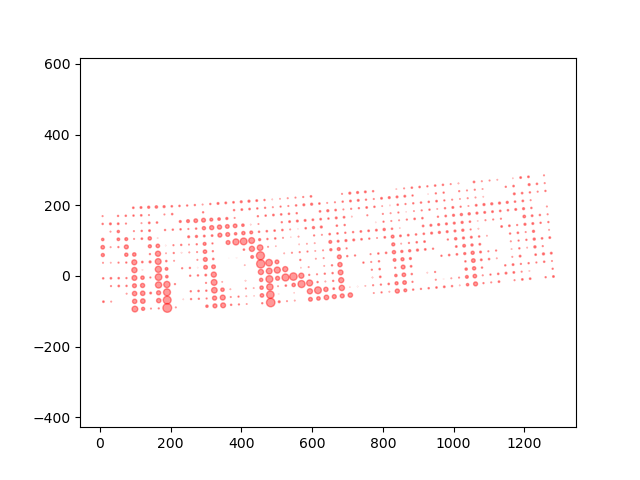

In [17]:
fig, ax = plt.subplots(1,1)
ax.scatter(*x_aE, s=2000*pos_max_eps_E, color='red', alpha=0.4)
ax.axis('equal')

# Discussion of approaches to an automatic crack detection

The goal is to use the above field representation with the help of interpolation functions
that can automatically detect the cracks and teeth at the ultimate state.

Interpolate the above grid using the shape functions
$$
e_E = N_{i} e_{Ei}
$$

The derivative of the principle tensile strain field can then be constructed as
$$
 \nabla_\boldsymbol{x} e_{E} = \nabla_\boldsymbol{x} N_i e_{Ei}
$$

Using the index notation $\boldsymbol{x} = x_a$, we can rewrite this equation as
$$
e_{E,a} = N_{i,a} e_{Ei}
$$

It is possible to pick also the direction of the principal tensile strain and then to 
use the approximation  

# Model component: **DICStrainGrid**

The above prototyping code has been implemented within the `DICStrainGrid` model component
as part of the `DICInspector`

In [18]:
from bmcs_shear.dic_crack import DICStrainGrid

In [19]:
dic_eps = DICStrainGrid(dic_grid=dic_grid)

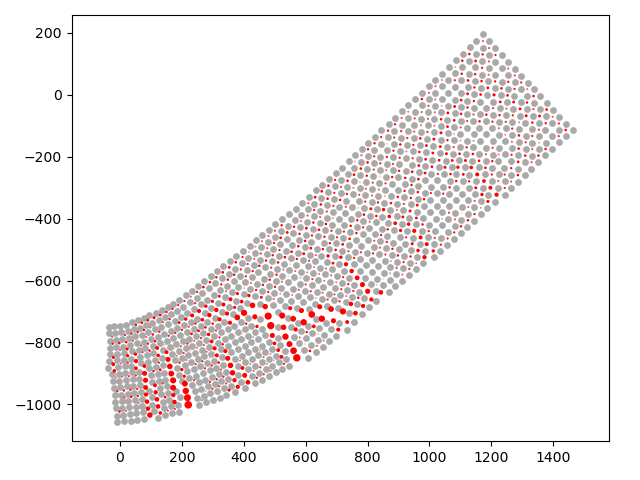

In [20]:
dic_eps.interact()